In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import ipywidgets as widgets

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100)

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [4]:
## This section define af bunch of functions in order to solve the model in period 2.

# Defining the utility function
def utility(c,rho):
    """ 
    The utility function 

    Args: 
        c (type: float): The consumption
        rho (type: float): The coeffcient of relative risk aversion. Have to be positive.

    Returns: 
        The utility (float) given consumption and coeffcient of relative risk aversion.      
    """
    
    return c**(1-rho)/(1-rho)


# Defining the net utility given level of human capital, labor supply and parameters
def v2(h2,l2,rho,gamma,w,b):
    """ 
    The net utility taking account for disutility of working 

    Args: 
        h2 (type: float, list): Level of human capital
        l2 (type: int, boolean): Dummy of working (l2=1) or not working (l2=0)
        rho (type: float): The coeffcient of relative risk aversion. Have to be positive.
        gamma (type: float): Meassuring the disutility of working. Have to be posistive.
        w (type: float): The wage. Have to be positive.
        b (type: float): The level of benefits if not working. Have to be positive.

    Returns: 
        The net utility (float,list) given level of human capital, labor supply and parameters.      
        The type depends on the type of h2
    """
    
    if l2 == 0: # Calculate the utility if not working
        return utility(b,rho)
    if l2 == 1: # Calculate the utility if working 
        return utility(w*h2,rho)-gamma*l2


# Defining function of the cutoff level of human capital so a person will choose to work in the second period
def h_cutoff(rho,gamma,w,b):
    """ 
    The cutoff level of human capital so a person will choose to work in the second period

    Args: 
        rho (type: float): The coeffcient of relative risk aversion. Have to be positive.
        gamma (type: float): Meassuring the disutility of working. Have to be posistive.
        w (type: float): The wage. Have to be positive.
        b (type: float): The level of benefits if not working. Have to be positive.

    Returns: 
        A value of human capital (float)     
    """
    
    # Defining function that is the squared difference between net utility of working and not working
    obj = lambda h: (v2(h,1,rho,gamma,w,b)-v2(h,0,rho,gamma,w,b))**2
    x0 = 0 # Initial guess
    
    # Find the cutoff value by minimizing the squared difference
    res_temp = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[0,10])

    return res_temp.x
    

# Define a function to 
def opt2(u2_nowork,u2_work):
    """ 
    Solves the model in the second period based on the utility of working and not working

    Args: 
        u2_nowork (type: list, tuple ndarray): A vector of utility if not working
        u2_work (type: list, tuple ndarray): A vector of utility if working

    Returns: 
        u2_opt: A vector (ndarray) of the optimal utility for different levels of human capital 
        l2_opt: A vector (list) of the optimal labor supply for different levels of human capital 
    """  
    
    # Create a new vector that is the maximum of the two utility vectors above 
    u2_opt = np.maximum(u2_work,u2_nowork)

    l2_opt = [] # Empty list for later purpose
    
    # Appending the optimal labor supply to the 'l2_opt'-list. Takes the value 1 
    # if utility of working is greater than the utility of not working
    for i in range(len(h_vec)):
        if u2_work[i]>=u2_nowork[i]:
            l2_opt.append(1)
        else:
            l2_opt.append(0)
   
    return u2_opt, l2_opt


# Defining function that solves the model in the second period, taking the level of human capital 
# as given (not as a function of human capital and labor supply in the first period)
def sol2(h_vec,rho,gamma,beta,w,b):
    """ 
    Solves the model in the second period taking the level of human capital 
    as given (not as a function of human capital and labor supply in the first period)

    Args: 
        h_vec (type: list, tuple, ndarray): Vector of different levels of human capital
        rho (type: float): The coeffcient of relative risk aversion. Have to be positive.
        gamma (type: float): Meassuring the disutility of working. Have to be posistive.
        w (type: float): The wage. Have to be positive.
        b (type: float): The level of benefits if not working. Have to be positive.

    Returns: 
        u2_nowork: A vector (ndarray) of the utility if not working for different levels of human capital 
        u2_work: A vector (ndarray) of the utility if  working for different levels of human capital 
        u2_opt: A vector (ndarray) of the optimal utility for different levels of human capital 
        l2_opt: A vector (list) of the optimal labor supply for different levels of human capital 
    """  
    
    # Generates two vectors: the net utility if working or not working for different levels of human capital
    u2_nowork = np.zeros(len(h_vec)) + v2(h_vec,0,rho,gamma,w,b)
    u2_work = v2(h_vec,1,rho,gamma,w,b)

    """    # Create a new vector that is the maximum of the two utility vectors above 
    u2_opt = np.maximum(u2_work,u2_nowork)

    
    l2_opt = [] # Empty list for later purpose
    
    # Appending the optimal labor supply to the 'l2_opt'-list. Takes the value 1 
    # if utility of working is greater than the utility of not working
    for i in range(len(h_vec)):
        if u2_work[i]>=u2_nowork[i]:
            l2_opt.append(1)
        else:
            l2_opt.append(0) """

    u2_opt, l2_opt = opt2(u2_nowork, u2_work)
    
    return u2_nowork, u2_work, u2_opt, l2_opt

In [5]:
# This part solves the model in the second perid and plot the utility and labor supply

# Call the optimal utility and labor supply as well as the utility of working and not 
u2_nowork, u2_work, u2_opt, l2_opt = sol2(h_vec,rho,gamma,beta,w,b)


# Plotting the utility levels and optimal level of labor supply
def fig1_1(plot_opt_u=False):
    """ Generates a two figures. One plotting the utility if working and not working. 
        The other plotting the optimal level of labor supply.

    Args: 
        plot_opt_u (type: Boolean): If true plots the optimal utility

    Returns: 
        One interactive plot and one 'normal' plot.  

    Notice: 
        The function is generated so that it can be called using widgets.interact()
        Thus, it is not intended to be used on its own. 
        """
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,10))

    # Sub_fig 1
    ax1.plot(h_vec,u2_nowork, label='Utility if $l_2=0$')
    ax1.plot(h_vec,u2_work, label='Utility if $l_2=1$')
    if plot_opt_u == True:
        ax1.plot(h_vec,u2_opt, label='Optimal utility')

    ax1.grid()
    ax1.legend(loc='lower right')
    ax1.set_xlabel('$h_2$')
    ax1.set_ylabel('Utility')
    ax1.set_title('Utility in $2^{nd}$ period');
    
    # Sub_fig two
    ax2.plot(h_vec,l2_opt)
    ax2.grid()
    ax2.set_xlabel('$h_2$')
    ax2.set_ylabel('Labor supply')
    ax2.set_title('Labor supply $2^{nd}$ period');

# Making the figure interactive so it is optional to plot the optimal utility
widgets.interact(fig1_1,
    plot_opt_u = widgets.RadioButtons(description='Plot opt. u', options=[False,True] 
                ),
);    

interactive(children=(RadioButtons(description='Plot opt. u', options=(False, True), value=False), Output()), …

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital).

In [6]:
# This part defines different functions to solve the model in the first period 

# Creating the expected level of human capital in period 2
def h2_exp(h1,l1):
    """ 
    The expected value of human capital in the second period 

    Args: 
        h1 (type: float, list): Level of human capital in the first period
        l1 (type: int, boolean): Labor supply in first period. Have to be a dummy or boolean

    Returns: 
        A value or vector of human capital (float/list). The type depends on the type of h1     
    """    
    
    return h1 + l1 + 0.25 # 0.25 is the expected value of the chok to human capital


# Defing function to calculate expected utility of period two
def v2_exp(h2_exp,rho,gamma,w,b):
    """ 
    The expected utility of period two

    Args: 
        h2_exp (type: list): List of expected levels of human capital
        rho (type: float): The coeffcient of relative risk aversion. Have to be positive.
        gamma (type: float): Meassuring the disutility of working. Have to be posistive.
        w (type: float): The wage. Have to be positive.
        b (type: float): The level of benefits if not working. Have to be positive.

    Returns: 
        v2: The expected utility (list) given level of human capital, labor supply in the first period and parameters.      
    """
    
    # Defining variable containing the cutoff value of human capital 
    # so a person will choose to work in the second period
    h2_cutoff = h_cutoff(rho,gamma,w,b)
    v2 = [] # Empty list for later purpose
    
    # Appending the expected utility in the second periods.
    # The utility depends on the expected level of human capital is above or below the cutoff value
    for i in range(len(h2_exp)):
        if h2_exp[i]>=h2_cutoff:
            v2.append(utility(w*h2_exp[i],rho)-gamma)
        if h2_exp[i]<h2_cutoff:
            v2.append(utility(b,rho))

    return v2

# Defining a function to calculate the net utility in period one 
# taking account for the expected utility in the second period
def v1(h1,l1,rho,gamma,beta,w,b):
    """ 
    The net utility in the first period taking account 
    for the expected utility in the second period

    Args: 
        h1 (type: float, list): Level of human capital
        l1 (type: int, boolean): Dummy of working (l2=1) or not working (l2=0)
        rho (type: float): The coeffcient of relative risk aversion. Have to be positive.
        gamma (type: float): Meassuring the disutility of working. Have to be posistive.
        beta (type: float): The discounting factor of the utilty in the second period. Have to be between 0 and 1.
        w (type: float): The wage. Have to be positive.
        b (type: float): The level of benefits if not working. Have to be positive.

    Returns: 
        The net utility (ndarray) given level of human capital, labor supply and parameters.      
    """   
    
    if l1 == 0:
        return utility(b,rho) + beta*np.array(v2_exp(h2_exp(h1,l1),rho,gamma,w,b))
    if l1 == 1:
        return utility(w*h1,rho) - gamma + beta*np.array(v2_exp(h2_exp(h1,l1),rho,gamma,w,b))



# Defining function to solve the model in period 1
def sol1(h1_vec,rho,gamma,beta,w,b):
    """ 
    Solves the model in the first period for different level of human capital. 
    
    Args: 
        h1_vec (type: list, tuple, ndarray): Vector of different levels of human capital
        rho (type: float): The coeffcient of relative risk aversion. Have to be positive.
        gamma (type: float): Meassuring the disutility of working. Have to be posistive.
        beta (type: float): The discounting factor of the utilty in the second period. Have to be between 0 and 1.
        w (type: float): The wage. Have to be positive.
        b (type: float): The level of benefits if not working. Have to be positive.

    Returns: 
        u1_nowork: A vector (ndarray) of the utility if not working for different levels of human capital 
        u1_work: A vector (ndarray) of the utility if  working for different levels of human capital 
        u1_opt: A vector (ndarray) of the optimal utility for different levels of human capital 
        l1_opt: A vector (ndarray) of the optimal labor supply for different levels of human capital 
    """  

    # Creating vectors of utility in the first period if not working and working
    u1_nowork = v1(h1_vec,0,rho,gamma,beta,w,b)
    u1_work = v1(h1_vec,1,rho,gamma,beta,w,b)

    # Create a new vector that is the maximum of the utility vectors above 
    u1_opt = np.maximum(u1_work,u1_nowork)

    l1_opt = [] # Empty list for later purpose
    
    # Appending the optimal labor supply to the 'l1_opt'-list. Takes the value 1 
    # if utility of working is greater than the utility of not working
    for i in range(len(h_vec)):
        if u1_work[i]>=u1_nowork[i]:
            l1_opt.append(1)
        else:
            l1_opt.append(0)

    return u1_nowork, u1_work, u1_opt, l1_opt


# Defining function that calculate the expected utility and labor supply 
# in the second period based on the labor supply and level of human capital in the first
def sol1_2(h1_vec,rho,gamma,beta,w,b):
    """ 
    Find the expected labor supply and utility in the second period 
    based on the labor supply and level of human capital in the first
    
    Args: 
        h1_vec (type: list, tuple, ndarray): Vector of different levels of human capital
        rho (type: float): The coeffcient of relative risk aversion. Have to be positive.
        gamma (type: float): Meassuring the disutility of working. Have to be posistive.
        beta (type: float): The discounting factor of the utilty in the second period. Have to be between 0 and 1.
        w (type: float): The wage. Have to be positive.
        b (type: float): The level of benefits if not working. Have to be positive.

    Returns: 
        u2_opt_nowork1: A vector (ndarray) of the utility in second period if not working in first period for different levels of human capital
        l2_opt_nowork1: A vector (list) of labor supply n second period if not working in first period for different levels of human capital
        u2_opt_work1: A vector (ndarray) of the utility in second period if working in first period for different levels of human capital
        l2_opt_work1: A vector (list) of labor supply n second period if working in first period for different levels of human capital
    """    
    
    # Expected level of utility in period 2 if not working in neither periods
    u2_nowork_nowork = np.zeros(len(h_vec)) + v2(h2_exp(h1_vec,0),0,rho,gamma,w,b)
    
    # Expected level of utility in period 2 if not working first period and working in second period
    u2_nowork_work = v2(h2_exp(h1_vec,0),1,rho,gamma,w,b)

    # Find the optimal level of utility and labor supply based on the two vectors of utility just calculated
    u2_opt_nowork1, l2_opt_nowork1 = opt2(u2_nowork_nowork,u2_nowork_work)


    # Expected level of utility in period 2 if working first period and not working in second period
    u2_work_nowork = np.zeros(len(h_vec)) + v2(h2_exp(h1_vec,1),0,rho,gamma,w,b)

    # Expected level of utility in period 2 if working in both periods
    u2_work_work = v2(h2_exp(h1_vec,1),1,rho,gamma,w,b)

    # Find the optimal level of utility and labor supply based on the two vectors of utility just calculated
    u2_opt_work1, l2_opt_work1 = opt2(u2_work_nowork,u2_work_work)

    return u2_opt_nowork1, l2_opt_nowork1, u2_opt_work1, l2_opt_work1


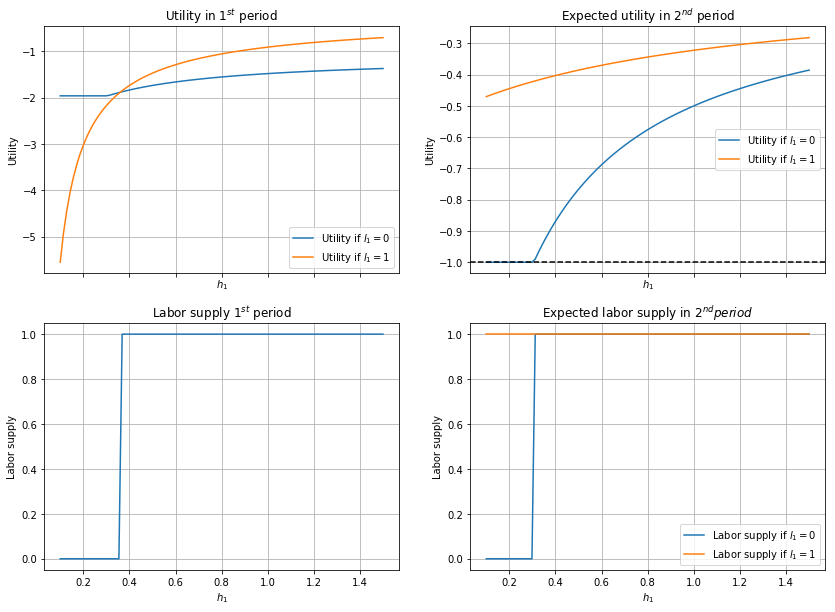

In [7]:
# This part solves the model in the first perid and plot the utility and labor supply

# Call the optimal utility and labor supply in the first period as well as the utility of working and not 
u1_nowork, u1_work, u1_opt, l1_opt = sol1(h_vec,rho,gamma,beta,w,b)

# Call the optimal utility and labor supply in the second period 
# depending on the working and not working in the first period 
u2_opt_nowork1, l2_opt_nowork1, u2_opt_work1, l2_opt_work1 = sol1_2(h_vec,rho,gamma,beta,w,b)


# Plot the various curves
fig1_2, ((ax1, ax3), (ax2, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14,10))

# Sub_fig 1
ax1.plot(h_vec,u1_nowork, label='Utility if $l_1=0$')
ax1.plot(h_vec,u1_work, label='Utility if $l_1=1$')
ax1.grid()
ax1.legend(loc='lower right')
ax1.set_xlabel('$h_1$')
ax1.set_ylabel('Utility')
ax1.set_title('Utility in $1^{st}$ period');

# Sub_fig2
ax2.plot(h_vec,l1_opt)
ax2.grid()
ax2.set_xlabel('$h_1$')
ax2.set_ylabel('Labor supply')
ax2.set_title('Labor supply $1^{st}$ period');

# Sub_fig3
ax3.plot(h_vec,u2_opt_nowork1, label='Utility if $l_1=0$')
ax3.plot(h_vec,u2_opt_work1, label='Utility if $l_1=1$')
ax3.grid()
ax3.legend(loc='center right')
ax3.set_xlabel('$h_1$')
ax3.set_ylabel('Utility')
ax3.axhline(y=utility(b,rho),color='black',linewidth=1.5, linestyle='dashed')
ax3.set_title('Expected utility in $2^{nd}$ period');

# Sub_fig4
ax4.plot(h_vec,l2_opt_nowork1, label='Labor supply if $l_1=0$')
ax4.plot(h_vec,l2_opt_work1, label='Labor supply if $l_1=1$')
ax4.grid()
ax4.legend(loc='lower right')
ax4.set_xlabel('$h_1$')
ax4.set_ylabel('Labor supply')
ax4.set_title('Expected labor supply in $2^{nd} period$');

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

In [8]:
# This section makes the same figures as in question 1.2, but where the values of the parameters can be adjusted 


# Defining a function to plot the optimal labor supply and utility in both periods
def fig1_3(w,b,gamma,beta):
    """ Generates a four figures. The first plotting the utility if working and not working in the first period. 
        The second plotting the optimal labor supply in the first period. The third plotting the optimal 
        utility in period two if working and not working in period two. The fourth plooting the optimal labor
        supply in period 2 if working and not working in period 1.

    Args: 
        gamma (type: float): Meassuring the disutility of working. Have to be posistive.
        beta (type: float): The discounting factor of the utilty in the second period. Have to be between 0 and 1.
        w (type: float): The wage. Have to be positive.
        b (type: float): The level of benefits if not working. Have to be positive.

    Returns: 
        Four interactive plots

    Notice: 
        The function is generated so that it can be called using widgets.interact()
        Thus, it is not intended to be used on its own. 
        """
    
    # Calling the vectors of utility and labor supply in the two periods
    u1_nowork, u1_work, u1_opt, l1_opt = sol1(h_vec,rho,gamma,beta,w,b)
    u2_opt_nowork1, l2_opt_nowork1, u2_opt_work1, l2_opt_work1 = sol1_2(h_vec,rho,gamma,beta,w,b)

    
    # Creating the figures
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(nrows=2,  ncols=2, sharex=True, figsize=(14,10))

    # Sub_fig 1
    ax1.plot(h_vec,u1_nowork, label='Utility if $l_1=0$')
    ax1.plot(h_vec,u1_work, label='Utility if $l_1=1$')
    ax1.grid()
    ax1.legend(loc='lower right')
    ax1.set_xlabel('$h_1$')
    ax1.set_ylabel('Utility')
    ax1.set_title('Utility in $1^{st}$ period');

    # Sub_fig2
    ax2.plot(h_vec,l1_opt)
    ax2.grid()
    ax2.set_xlabel('$h_1$')
    ax2.set_ylabel('Labor supply')
    ax2.set_ylim([-0.1,1.1])
    ax2.set_title('Labor supply $1^{st}$ period');
    
    # Sub_fig3
    ax3.plot(h_vec,u2_opt_nowork1, label='Utility if $l_1=0$')
    ax3.plot(h_vec,u2_opt_work1, label='Utility if $l_1=1$')
    ax3.grid()
    ax3.legend(loc='lower right')
    ax3.set_xlabel('$h_1$')
    ax3.set_ylabel('Utility')
    ax3.set_ylim([utility(b,rho)-0.5,0])
    ax3.axhline(y=utility(b,rho),color='black',linewidth=1.5, linestyle='dashed')
    ax3.set_title('Expected utility in $2^{nd}$ period');

    # Sub_fig4
    ax4.plot(h_vec,l2_opt_nowork1, label='Labor supply if $l_1=0$')
    ax4.plot(h_vec,l2_opt_work1, label='Labor supply if $l_1=1$')
    ax4.grid()
    ax4.legend(loc='lower right')
    ax4.set_xlabel('$h_1$')
    ax4.set_ylabel('Labor supply')
    ax4.set_ylim([-0.1,1.1])
    ax4.set_title('Expected labor supply in $2^{nd} period$');


widgets.interact(fig1_3,
    b = widgets.FloatSlider(
                    value=1,
                    description='Benefits', 
                    min=0,
                    max=3, 
                    step=0.1,
                    ),
    w = widgets.FloatSlider(
                    value=2,
                    description='Wage', 
                    min=0,
                    max=3, 
                    step=0.1,
                    ),
    gamma = widgets.FloatSlider(
                    value=0.1,
                    description='$\gamma$', 
                    min=0,
                    max=1, 
                    step=0.1,
                    ),
    beta = widgets.FloatSlider(
                value=0.96,
                description='$\\beta$', 
                min=0,
                max=1, 
                step=0.05,
                )
); 



interactive(children=(FloatSlider(value=2.0, description='Wage', max=3.0), FloatSlider(value=1.0, description=…

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [9]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [10]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [11]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [12]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?